# Goal

This notebook checks model generalization performance on other dsets.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# INFERENCE DATALOADER PARAMS
num_workers = 4

# Items

In [3]:
from pathlib import Path
from helpers.items_constants import *

dsets_src    = f"{data_src}/PitMRdata"

# key,val = dset_name, path to top level dir
dset_dict = {
    "ABIDE"                  : f"{dsets_src}/ABIDE",
    "ABVIB"                  : f"{dsets_src}/ABVIB/ABVIB",
    "ADNI1_Complete_1Yr_1.5T": f"{dsets_src}/ADNI/ADNI1_Complete_1Yr_1.5T/ADNI",
    "AIBL"                   : f"{dsets_src}/AIBL/AIBL",
    "ICMB"                   : f"{dsets_src}/ICMB/ICBM",
    "PPMI"                   : f"{dsets_src}/PPMI/PPMI",
}

ppmi  = [i for i in cross_lbl_items if dset_dict["PPMI"] in i[0]]
icmb = [i for i in cross_lbl_items if "ICMB" in i[1]]
adni = [i for i in cross_lbl_items if "ADNI1_full" in i[1]]
aibl = [i for i in cross_lbl_items if "AIBL" in i[1]]
abvib = [i for i in cross_lbl_items if "ABVIB" in i[1]]

print(len(ppmi))
print(len(icmb))
print(len(adni))
print(len(aibl))
print(len(abvib))
print(len(test_items), len(valid_items), len(train_items))

Full lbl items: 335
Removed 2 weird, new total lbl items: 333
train, valid, test 201 66 66 total 333
Cross label items:  418
All label items:  751 (abide (333) + cross_lbl (418))
Test label items:  484 (test (66) + cross_lbl (418))
95
52
90
89
92
66 66 201


In [4]:
print(len(cross_lbl_items))
print(len(ppmi)+len(icmb)+len(adni)+len(aibl)+len(abvib))

418
418


In [5]:
# Items as dict 
from pathlib import Path
from helpers.items_constants import *

#items  = all_test_lbl_items
items = all_test_lbl_items #ppmi, icmb, adni, aibl, abvib, test_items
itemsd = getd(items)

print(f"n = {len(itemsd)}, test items = {len(test_items)}, other dsets = {len(cross_lbl_items)}")
print(f"first item", itemsd[0])

n = 484, test items = 66, other dsets = 418
first item {'image': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/MP-RAGE/2000-01-01_00_00_00.0/S165075/ABIDE_50011_MRI_MP-RAGE_br_raw_20120830203207657_S165075_I329085_corrected_n4.nii', 'label': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50011/seg.nii'}


In [6]:
import os
import shutil
import tempfile
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.config import print_config
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.7.dev2131
Numpy version: 1.19.5
Pytorch version: 1.7.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 57467c75bff90e6c9da74461f7da3a828a39626b

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.8.2+cu101
tqdm version: 4.62.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Transforms

In [7]:
from helpers.transforms import get_train_valid_transforms

full_res = (96,96,96)
pixdim   = (1.5,1.5,1.5)
train_tfms, val_tfms = get_train_valid_transforms(pixdim=pixdim,full_res=full_res)
print(f"val tfms: ", *val_tfms.transforms, sep="\n")

val tfms: 
UndoDict


In [8]:
from pprint import pprint, pformat
def get_tfm_d(tfm):
    d = {}
    for k,v in tfm.__dict__.items():
        if k not in ("image_key", "label_ley", "allow_missing_keys"):
            d[k] = v
            try:
                d.update(v.__dict__)
                #print(v.__dict__)
            except:
                pass
    return d

def monai_tfms2str(tfms):
    simple = "\n".join([str(tfm) for tfm in tfms.transforms])
    sep = "\n" + "*"*50 + "\n"
    details = sep.join([str(tfm)+"\n"+str(pformat(get_tfm_d(tfm), indent=4)) for tfm in tfms.transforms])
    return simple + sep + details

In [9]:
print(monai_tfms2str(train_tfms))
print(monai_tfms2str(val_tfms))

UndoDict
**************************************************
{   '_loader': <monai.transforms.io.array.LoadImage object at 0x2aab6319d5f8>,
    'dtype': <class 'numpy.float32'>,
    'image_only': False,
    'keys': ('image', 'label'),
    'meta_key_postfix': ('meta_dict', 'meta_dict'),
    'meta_keys': (None, None),
    'overwriting': False,
    'readers': [   <monai.data.image_reader.ITKReader object at 0x2aab631b6860>,
                   <monai.data.image_reader.NibabelReader object at 0x2aab6c83d080>]}
**************************************************
{   'align_corners': (False, False),
    'diagonal': False,
    'dtype': (<class 'numpy.float64'>, <class 'numpy.float64'>),
    'keys': ('image', 'label'),
    'meta_key_postfix': ('meta_dict', 'meta_dict'),
    'meta_keys': (None, None),
    'mode': ('bilinear', 'nearest'),
    'padding_mode': (   <GridSamplePadMode.BORDER: 'border'>,
                        <GridSamplePadMode.BORDER: 'border'>),
    'pixdim': array([1.5, 1.5, 1.5]),

# Model

In [10]:
model_names = {
    "unet_bce": "model_UNET3D_loss_BCE_loss_bs_1_epochs_60_time_1627647477_Fri_Jul_30_2021_hr_08_min_17",
    "obelisk_bce": "model_OBELISKHYBRID_loss_BCE_loss_bs_1_epochs_60_time_1627823459_Sun_Aug_01_2021_hr_09_min_10",
    "vnet_bce": "model_VNET_loss_BCE_loss_bs_1_epochs_60_time_1627823149_Sun_Aug_01_2021_hr_09_min_05",
    "unetr_bce": "model_UNETR_loss_BCE_loss_bs_1_epochs_60_time_1627830873_Sun_Aug_01_2021_hr_11_min_14"
}

model_name = model_names["unetr_bce"]

In [11]:
# model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)
# model_fns = [str(p) for p in model_fns]

# #model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
# model_idx = 2
# model_name   = Path(model_fns[model_idx]).name
# print(f"Chosen: {model_name}")
# print(f"Prior: ", *[f"{idx}: {model_fn[len(run_src):]}" for idx,model_fn in enumerate(model_fns[:5])], sep="\n")

In [12]:
from helpers.general            import get_param
from helpers.model_loss_choices import get_model, get_loss


model_type = get_param(model_name, "model_", "_loss")
loss_type  = get_param(model_name, "loss_", "_bs")

model   = get_model(model_type, full_res)
loss_fn = get_loss(loss_type) 

# print
print("Model name: ", model_name)
print(f"Model type: {model_type}. Loss type: {loss_type}.")

Model name:  model_UNETR_loss_BCE_loss_bs_1_epochs_60_time_1627830873_Sun_Aug_01_2021_hr_11_min_14
Model type: UNETR. Loss type: BCE_loss.


# Dataloaders

In [13]:
# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *

In [14]:
from transforms import UndoDict

# time it - 18s for 484 items
start = time.time()

# tls, dls, cuda
bs  = 5
tls = TfmdLists(itemsd, val_tfms)
dls = tls.dataloaders(bs=bs, after_batch=[], num_workers=num_workers, drop_last=False)
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed:.2f} s for {len(itemsd)} items")

Elapsed time: 9.58 s for 484 items


In [ ]:
# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train_ds)}, n_valid = {len(dls.valid_ds)}, n = {len(itemsd)}")

In [ ]:
# count = 0
# for i,item in enumerate(tls):
#     if item[0].shape[-1] != 96 or item[1].shape[-1] != 96:
#         print(i, item[0].shape, item[1].shape)
#         print(itemsd[i])
#         print();
        
#         count += 1
#         if count == 4:
#             break

In [ ]:
from pprint import pprint, pformat
def get_tfm_d(tfm):
    d = {}
    for k,v in tfm.__dict__.items():
        if k not in ("image_key", "label_ley", "allow_missing_keys"):
            d[k] = v
            try:
                d.update(v.__dict__)
                #print(v.__dict__)
            except:
                pass
    return d

def monai_tfms2str(tfms):
    simple = "\n".join([str(tfm) for tfm in tfms.transforms])
    sep = "\n" + "*"*50 + "\n"
    details = sep.join([str(tfm)+"\n"+str(pformat(get_tfm_d(tfm), indent=4)) for tfm in tfms.transforms])
    return simple + sep + details


# print("Train Tfms: "), print(monai_tfms2str(train_tfms)); print("\n");
# print("Valid Tfms: \n", monai_tfms2str(val_tfms))


In [ ]:
# item = {'image': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50379/MP-RAGE/2000-01-01_00_00_00.0/S165402/ABIDE_50379_MRI_MP-RAGE_br_raw_20120830233630136_S165402_I329412_corrected_n4.nii', 'label': '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50379/seg.nii'}
# ss = []

# last = item
# for i, tfm in enumerate(val_tfms.transforms):
#     last = tfm(last)
#     ss.append(last)
#     try:
#         print(i, tfm, last["image"].shape)
#     except:
#         print(i, tfm)

# Learner

In [15]:
import gc
gc.collect()

29

In [16]:
from helpers.losses import dice_score

In [17]:
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_fn,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{run_src}/{model_name}/model")

In [18]:
# all predictions, 67 items, 4 workers, 15sec
# Elapsed: 326.07 s for 484 items.
start = time.time()
predictions, targets = learn.get_preds(dl=dls.train)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(itemsd)} items.")

Elapsed: 109.76 s for 484 items.


In [ ]:
# 30 sec for 67 test items (2 CPU workers)
start = time.time()
print(learn.validate(ds_idx=0))
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {(len(itemsd))} items.")

In [ ]:
print("Pred mask", predictions.shape, "Target (x = y = MR)", targets.shape)
print("Pred mask", predictions[0].shape, "Target", targets[0].shape)

In [ ]:
from helpers.preprocess import batch_get_bbox

# Elapsed 65.148959 s
start = time.time()

# get masks and probs
pred_masks = torch.argmax(predictions, dim=1).byte()
pred_bboxs = batch_get_bbox(pred_masks)
gt_bboxs   = batch_get_bbox(targets)
#pred_probs = np.asarray(predictions.softmax(1)[:,1].cpu())

elapsed = time.time() - start
print(f"Elapsed {elapsed:2f} s")

In [ ]:
%debug

# Test set: Prediction Dice Distribution

In [19]:
from monai.losses import DiceLoss

dice_loss = DiceLoss(
    include_background=False, 
    to_onehot_y=False, 
    sigmoid=False, 
    softmax=False, 
    other_act=None, 
    squared_pred=False, 
    jaccard=False, 
    reduction="none", 
    smooth_nr=0, #1e-05, 
    smooth_dr=0, #1e-05, 
    batch=False)

# dice_loss_soft = DiceLoss(
#     include_background=False, 
#     to_onehot_y=False, 
#     sigmoid=True, 
#     softmax=False, 
#     other_act=None, 
#     squared_pred=False, 
#     jaccard=False, 
#     reduction="none", 
#     smooth_nr=0, #1e-05, 
#     smooth_dr=0, #1e-05, 
#     batch=False)

start = time.time()

indiv_dices = dice_loss(predictions.argmax(1).unsqueeze(1), targets)
#indiv_dices = dice_loss_soft(predictions[:,1].unsqueeze(1), targets)
indiv_dices = [1-dice_loss for dice_loss in indiv_dices]
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

Elapsed: 66.61 s for 484 items.


In [ ]:
# start = time.time()

# indiv_dices = [dice_score(predictions[i].unsqueeze(0), targets[i].unsqueeze(0)) for i in range(len(targets))]
# elapsed = time.time() - start

# print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

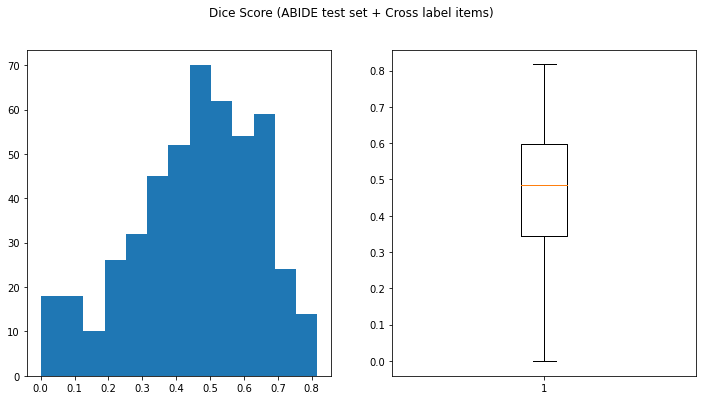

Elapsed: 0.29 s for 484 items.


In [20]:
start = time.time()

# sort dices from low to high
sorted_dice_idxs  = sorted(range(len(indiv_dices)), key=lambda i:indiv_dices[i].item()) 
np_indiv_dices = np.array([indiv_dices[i].item() for i in sorted_dice_idxs])

# plot
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

fig1.suptitle("Dice Score (ABIDE test set + Cross label items)")
plt.show()

# time
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [ ]:
# fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
# ax0.hist(np_indiv_dices, bins="auto")
# ax1.boxplot(np_indiv_dices)
# plt.show()

In [23]:
# num dices under 0.6
threshold = 0.6
lows = [(i,dice) for i,dice in zip(sorted_dice_idxs, np_indiv_dices) if dice < threshold]

if len(lows) > 0:
    low_dice_idxs, low_dices = zip(*lows)
else:
    low_dice_idxs, low_dices = [],[]

print(len(low_dices), low_dice_idxs)
print(*[f"Dice {indiv_dices[i].item()}, \n fn: {items[i][0][len(data_src):]} \n" for i in low_dice_idxs], sep="\n")

print("Median dice: ", np.median(np.asarray(indiv_dices)), "Mean", np.asarray(indiv_dices).mean(), "+- std", np.asarray(indiv_dices).std())

364 (221, 229, 454, 301, 473, 186, 460, 265, 227, 268, 213, 249, 292, 251, 445, 359, 207, 157, 285, 237, 260, 233, 185, 242, 276, 346, 197, 234, 308, 297, 183, 216, 198, 284, 397, 215, 243, 255, 476, 259, 358, 97, 351, 306, 457, 67, 383, 177, 235, 368, 187, 244, 283, 323, 363, 389, 338, 280, 271, 466, 241, 195, 422, 230, 205, 139, 203, 386, 231, 204, 225, 217, 282, 220, 179, 281, 417, 167, 302, 110, 315, 79, 372, 321, 350, 115, 168, 257, 354, 135, 68, 267, 374, 98, 331, 352, 190, 228, 423, 467, 202, 25, 111, 120, 169, 412, 134, 286, 172, 432, 299, 324, 401, 404, 210, 441, 245, 94, 371, 290, 165, 126, 332, 273, 378, 360, 128, 222, 399, 78, 477, 322, 336, 262, 313, 188, 348, 99, 80, 171, 464, 118, 303, 155, 164, 272, 212, 224, 104, 339, 342, 142, 184, 279, 420, 129, 345, 194, 90, 114, 463, 304, 93, 156, 357, 214, 287, 300, 121, 218, 274, 143, 181, 124, 270, 387, 88, 136, 240, 192, 440, 153, 73, 462, 330, 429, 85, 349, 329, 411, 316, 264, 307, 83, 277, 469, 356, 388, 328, 22, 296, 107, 39

In [24]:
test_idxs  = [idx for idx,i in enumerate(items) if "ABIDE" in i[0]] 
ppmi_idxs  = [idx for idx,i in enumerate(items) if dset_dict["PPMI"] in i[0]]
icmb_idxs  = [idx for idx,i in enumerate(items) if "ICMB" in i[1]]
adni_idxs  = [idx for idx,i in enumerate(items) if "ADNI1_full" in i[1]]
aibl_idxs  = [idx for idx,i in enumerate(items) if "AIBL" in i[1]]
abvib_idxs = [idx for idx,i in enumerate(items) if "ABVIB" in i[1]]

print(len(test_idxs))
print(len(ppmi_idxs))
print(len(icmb_idxs))
print(len(adni_idxs))
print(len(aibl_idxs))
print(len(abvib_idxs))
print(len(test_items), len(valid_items), len(train_items))

66
95
52
90
89
92
66 66 201


In [22]:
names = ["ABIDE", "PPMI", "ICMB", "ADNI", "AIBL", "ABVIB"]
idxs  = [test_idxs, ppmi_idxs, icmb_idxs, adni_idxs, aibl_idxs, abvib_idxs]

for name,name_idxs in zip(names, idxs):
    subset_idxs = np.array([indiv_dices[i].item() for i in name_idxs])
    print(name, ": ", "Median dice: ", np.median(subset_idxs), "Mean",subset_idxs.mean(), "+- std", subset_idxs.std())

ABIDE :  Median dice:  0.6694340407848358 Mean 0.6564745036038485 +- std 0.09527288462907642
PPMI :  Median dice:  0.4878140687942505 Mean 0.4815761214808414 +- std 0.1365940482665498
ICMB :  Median dice:  0.38796404004096985 Mean 0.37923022416921764 +- std 0.16368800687340077
ADNI :  Median dice:  0.3452548384666443 Mean 0.338095262977812 +- std 0.2124100155704381
AIBL :  Median dice:  0.4326540231704712 Mean 0.4271009209450711 +- std 0.15273683311078368
ABVIB :  Median dice:  0.5108175575733185 Mean 0.4790758173102918 +- std 0.16416742960396163


In [ ]:
np.median([1,2,3,4,5])

# Isoperimetric ratios

# Probs

In [ ]:
probs = predictions.softmax(1)[:,1]
print(f"Probs", probs.shape)

In [ ]:
from matplotlib import colors

prob_cmap  = "GnBu" #"hot" https://matplotlib.org/stable/tutorials/colors/colormaps.html 
bin_cmap1  = colors.ListedColormap(['white', 'yellow'])
bin_cmap2  = colors.ListedColormap(['white', 'red'])

for idx in sorted_dice_idxs[:10]:

    print(f"Worst idx: {idx}. mr: {items[idx][0][len(data_src)+1:]}")
    
    gt_bbox   = gt_bboxs[idx]
    pred_bbox = pred_bboxs[idx]
    
    gt_map    = targets[idx].squeeze()
    prob_map  = probs[idx]
    pred_mask = pred_masks[idx]

    # max difference
    d = torch.abs(gt_map-prob_map)

    # along axis 0,1,2
    a0 = torch.sum(torch.sum(d, dim=2), dim=1)
    a1 = torch.sum(torch.sum(d, dim=2), dim=0)
    a2 = torch.sum(torch.sum(d, dim=1), dim=0)
    a0max, a0_idx = torch.max(a0), torch.argmax(a0)
    a1max, a1_idx = torch.max(a1), torch.argmax(a1)
    a2max, a2_idx = torch.max(a2), torch.argmax(a2)
    
    # plot
    fig, axes = plt.subplots(3,4, figsize=(12,12))
    for i in range(3):
        max_diff_idx = [a0_idx, a1_idx, a2_idx][i]
        
        gt_slice, prob_slice, pred_slice = [np.take(np.asarray(m), max_diff_idx, axis=i) for m in (gt_map, prob_map, pred_mask)]
        
        axes[i,0].imshow(gt_slice,   cmap=bin_cmap1)
        axes[i,0].imshow(pred_slice, cmap=bin_cmap2, alpha=0.5)
        axes[i,1].imshow(gt_slice,   cmap=bin_cmap1)
        im  = axes[i,2].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest')  
        im2 = axes[i,3].imshow(np.log(prob_slice), cmap=prob_cmap, interpolation='nearest')  

        axes[i,0].set_title(f"Slice {max_diff_idx} (Axis {i})")
        axes[i,1].set_title(f"GT map")
        axes[i,2].set_title(f"Prob map")
        axes[i,3].set_title(f"Log Prob map")
        
        # colorbar
        fig.colorbar(im,  ax=axes[i,2])
        fig.colorbar(im2, ax=axes[i,3])

    plt.show()

# Viz worst

In [ ]:
import SimpleITK as sitk
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs

In [ ]:
from helpers.general import round_tuple

In [ ]:
worst_idx = low_dice_idxs[0]
best_idx  = sorted_dice_idxs[-1]
print("Worst. Idx = ", worst_idx, "Dice: ", indiv_dices[worst_idx], items[worst_idx][0]); print()
print("Best. Idx = ", best_idx, "Dice: ",   indiv_dices[best_idx], items[best_idx][0])

# get dirs
worst_fn = items[worst_idx][0]
best_fn  = items[best_idx][0]

print(f"Worst fname: {worst_fn[len(data_src):]}"); print()
print(f"best fname: {best_fn[len(data_src):]}")

for fn in (worst_fn, best_fn):
    # get stated direction
    sitk_obj = sitk.ReadImage(fn, sitk.sitkFloat32)
    sitk_dir = sitk_obj.GetDirection()

    # get stated orientation
    orient = sitk.DICOMOrientImageFilter()
    sitk_ori = orient.GetOrientationFromDirectionCosines(sitk_dir)
    
    # print
    print(f"Dir {round_tuple(sitk_dir)}, Ori {sitk_ori}")

def get_input(idx):
    mr1,mk1 = tls[idx]
    return mr1.squeeze(), mk1.squeeze()

input1 = get_input(worst_idx)
input2 = get_input(best_idx)
    
for axis in range(3):
    viz_compare_inputs(input1, input2, axis=axis)

In [ ]:
from helpers.viz import get_mid_range

In [ ]:
from matplotlib import colors
bin_cmap2  = colors.ListedColormap(['white', 'yellow'])

In [ ]:
# intensity

worst_idxs = sorted_dice_idxs[:5]
best_idxs  = sorted_dice_idxs[-5:]

_, axes = plt.subplots(10,3, figsize=(6,12))

for i in range(5):
    w_idx = worst_idxs[i]
    b_idx = best_idxs[i]
    
    input1 = get_input(w_idx)
    input2 = get_input(b_idx)

    bbox1 = gt_bboxs[w_idx]
    bbox2 = gt_bboxs[b_idx]
    
    # plot
    for axis in range(3):
        start_idx1, end_idx1 = get_mid_range(bbox1, axis, nslices=1)
        start_idx2, end_idx2 = get_mid_range(bbox2, axis, nslices=1)
        
        # WORST: mid-slice in axis
        axes[2*i, axis].imshow(np.take(np.rot90(input1[0]), start_idx1, axis=axis)) #, cmap=plt.cm.gray)
        #axes[2*i, axis].imshow(np.take(np.rot90(input1[1]), start_idx1, axis=axis), cmap=bin_cmap2, alpha=0.5)
        
        # BEST: mid-slice in axis
        axes[2*i+1, axis].imshow(np.take(np.rot90(input2[0]), start_idx2, axis=axis)) #, cmap=plt.cm.gray)
        #axes[2*i+1, axis].imshow(np.take(np.rot90(input2[1]), start_idx2, axis=axis), cmap=bin_cmap2, alpha=0.5)

plt.show()

In [ ]:
# intensity hist

worst_idxs = sorted_dice_idxs[:5]
best_idxs  = sorted_dice_idxs[-5:]

#fig = plt.figure(constrained_layout=True)

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
fig.suptitle('MR Intensity Histogram')

axes[0,0].set_yscale('log')
axes[0,2].set_title("Worst")
axes[1,2].set_title("Best")
# subfigs = fig.subfigures(nrows=2, ncols=1)
# subfigs[0].suptitle(f'Worst');
# subfigs[1].suptitle(f'Best')

# axs = []
# for subfig in subfigs:
#     # create 1x3 subplots per subfig
#     axs.append(subfig.subplots(nrows=1, ncols=5))
# axs = np.asarray(axs)    
# #, axes = plt.subplots(2,5, figsize=(6,12))

for i in range(5):
    w_idx = worst_idxs[i]
    b_idx = best_idxs[i]
    
    input1 = get_input(w_idx)
    input2 = get_input(b_idx)

    mr1, mk1 = input1
    mr2, mk2 = input2
    
    mr1, mk1 = np.asarray(mr1), np.asarray(mk1)
    mr2, mk2 = np.asarray(mr2), np.asarray(mk2)
    
    # plot
    
    axes[0,i].hist(mr1[mr1>0].reshape(-1,))
    axes[1,i].hist(mr2[mr2>0].reshape(-1,))
    
plt.show()

# Viz all worst

In [ ]:
#for n_worst in range(len(low_dice_idxs)):
for n_worst in range(len(low_dice_idxs)):
    idx = low_dice_idxs[n_worst]

    mr, mk       = get_input(idx)
    pred, target = predictions[idx], targets[idx].squeeze()

    dice = dice_score(pred.unsqueeze(0), target.unsqueeze(0).unsqueeze(0))
    
    print(f"Worst #{n_worst}. Dice {dice:.3f}")
    print(f"fn: {items[idx][0][len(data_src)+1:]}")
    print(f"*"*100)
    
    print("GT bbox and Pred bbox: ", gt_bboxs[idx], pred_bboxs[idx])

    viz_compare_outputs(mr, target, pred)

# Post-processing

1. Largest Connect Label

In [ ]:
# source sitk 36_Microscopy_Colocalization_Distance_Analysis.html
def get_largest_connected_component(binary_seg):
    # tensor to sitk
    #binary_seg = sitk.GetImageFromArray(binary_seg)
    
    # connected components in sitkSeg
    labeled_seg = sitk.ConnectedComponent(binary_seg)

    # re-order labels according to size (at least 1_000 pixels = 10x10x10)
    labeled_seg = sitk.RelabelComponent(labeled_seg, minimumObjectSize=1000, sortByObjectSize=True)

    # return segm of largest label
    binary_seg = labeled_seg == 1
    
    return binary_seg
    # sitk to tensor
    #return torch.tensor(sitk.GetArrayFromImage(binary_seg))

# eval metrics

In [ ]:
# evaluate
filters = [sitk.LabelOverlapMeasuresImageFilter(), sitk.HausdorffDistanceImageFilter()]
methods = [
    [
        sitk.LabelOverlapMeasuresImageFilter.GetDiceCoefficient, 
        sitk.LabelOverlapMeasuresImageFilter.GetFalseNegativeError, 
        sitk.LabelOverlapMeasuresImageFilter.GetFalsePositiveError
    ],
    [sitk.HausdorffDistanceImageFilter.GetHausdorffDistance]
]

names = [
    ["dice", "false_neg", "false_pos"],
    ["hausdorff_dist"]
]

In [ ]:
# d{"dice": x, "Hausdorff": y, "false pos": z}
def eval_measure(ground_truth, after_registration, names_todo=None):
    if isinstance(names_todo, str): names_todo = [names_todo]
        
    d = {}
    for f,method_list, name_list in zip(filters, methods, names):
        for m,n in zip(method_list, name_list):
            if not names_todo or n in names_todo:
                try:
                    f.Execute(ground_truth, after_registration)
                    val = m(f)
                except Exception as e:
                    print(e)
                    val = "-99"
                d[n] = val
    return d

# apply post-process

In [ ]:
from helpers.preprocess import mask2bbox, sitk2np

In [ ]:
i  = 0
y = sitk.GetImageFromArray(torch.transpose(targets[i].squeeze(), 0, 2).byte())
p = sitk.GetImageFromArray(torch.transpose(pred_masks[i], 0, 2).byte())
p2 = get_largest_connected_component(p)

print(mask2bbox(sitk2np(y)))
print(mask2bbox(sitk2np(p)))
print(mask2bbox(sitk2np(p2)))

print(y.GetSize(), p.GetSize(), p2.GetSize())

e = eval_measure(y, p)
e2 = eval_measure(y, p2)

print(e, e2)                

In [ ]:
assert np.array_equal(np.array(pred_masks[0]), np.array(torch.argmax(predictions[0], dim=0)))

In [ ]:
def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)

start = time.time()

pre_df = [
    eval_measure(torch2sitk(targets[i].squeeze().byte()), 
                 torch2sitk(pred_masks[i].byte())
                )
    for i in range(len(predictions))
]
                 
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(predictions)} items.")

In [ ]:
def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)

start = time.time()

metrics_df = [
    eval_measure(torch2sitk(targets[i].squeeze().byte()), 
                 get_largest_connected_component(torch2sitk(pred_masks[i].byte()))
                )
    for i in range(len(predictions))
]
                 
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(predictions)} items.")

In [ ]:
pre_df     = pd.DataFrame(pre_df)
metrics_df = pd.DataFrame(metrics_df)

for name_lst in names:
    for name in name_lst:
        pre_mean = pre_df[name].mean()
        post_mean = metrics_df[name].mean()
        delta = post_mean - pre_mean
        print(f"{name}: diff = {delta:0.4f} ({pre_mean: 0.4f} ==> {post_mean:0.4f})")

In [ ]:
metrics_df

In [ ]:
# post_preds = [get_largest_connected_component(pred.argmax(0)) for pred in predictions]

# Shape of Largest connected component

In [ ]:
lccs = [sitk2torch(get_largest_connected_component(torch2sitk(x.byte()))) for x in pred_masks]

In [ ]:
len(lccs), lccs[0].shape

In [ ]:
lccs_all = torch.stack(lccs, dim=0)
print(lccs_all.shape)

In [ ]:
lccs_all.shape

In [ ]:
lccs_all[:20].unsqueeze(1).shape

In [ ]:
from helpers.isoperim import get_iso_ratio

In [ ]:
start = time.time()
pred_ratios = get_iso_ratio(predictions)
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s.")

In [ ]:
start = time.time()
lcc_ratios = get_iso_ratio(lccs_all.unsqueeze(1))
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s.")

In [ ]:
targets.shape

In [ ]:
start = time.time()
target_ratios = get_iso_ratio(targets)
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s.")

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(12,12))
axes[0,0].hist(np.asarray(target_ratios))
axes[0,0].set_title("Target Isoperimetric ratio")
axes[0,1].boxplot(np.asarray(target_ratios))

axes[1,0].hist(np.asarray(ratios))
axes[1,0].set_title("Largest Connected Component Isoperimetric ratio")
axes[1,1].boxplot(np.asarray(ratios))

diff = ratios - target_ratios
axes[2,0].hist(np.asarray(diff))
axes[2,0].set_title("Difference in Isoperimetric ratio")
axes[2,1].boxplot(np.asarray(diff))

In [ ]:
ratios

In [ ]:
prediction_ratios = get_isoperimetric_ratio(*get_vol_sa(get_largest_connected_component()

In [ ]:
target_ratios     = get_isoperimetric_ratio(*get_vol_sa(targets))
prediction_ratios = get_isoperimetric_ratio(*get_vol_sa(predictions))

_, axes = plt.subplots(1,2)
axes[0].hist(np.asarray(target_ratios))
axes[1].hist(np.asarray(prediction_ratios))
axes[0].set_title("Target Isometric Ratio")
axes[1].set_title("Pred Isometric Ratio")

# Convert

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = nb_name
output_file_name = notebook_name[:-6] + "_viz_probs_BCE_July_31" + '.html'

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

# End

In [ ]:
print("Done")